# 利用MindQuantum解决组合优化问题

In [1]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
Looking in links: https://obs-workspace-20180810.obs.cn-north-1.myhuaweicloud.com/pypi/index.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import networkx as nx

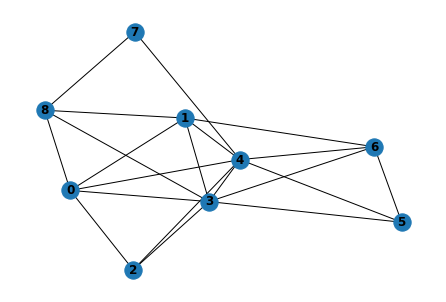

In [3]:
g = nx.gnm_random_graph(9, 20, seed=42)
nx.draw(g,with_labels=True, font_weight='bold')

In [4]:
print(list(g.edges))

[(0, 1), (0, 8), (0, 2), (0, 4), (0, 3), (1, 8), (1, 6), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (3, 8), (3, 6), (3, 5), (4, 7), (4, 5), (4, 6), (5, 6), (7, 8)]


## nx库中的解法

In [5]:
cut, partition = nx.algorithms.approximation.one_exchange(g)
print(cut, partition)

14 ({8, 3, 4}, {0, 1, 2, 5, 6, 7})


## Try to solve by yourself

In [6]:
import itertools
def score(x,edges):
    c = 0
    for index in edges:
        e1 = index[0]
        e2 = index[1]
        tmp = x[e1]*(1-x[e2]) + (1-x[e1])*x[e2] 
        c += tmp
    return c
def solution(edges):
    scores = []
    max_strings = []
    perms = ["".join(seq) for seq in itertools.product("01", repeat = len(g.nodes()))]
    for xk in  perms:
        tmp = list(map(int,str(xk)))
        Ek = score(tmp,edges)
        scores.append(Ek)
    max_score = max(scores)
    for k in range(len(scores)):
        score_k = scores[k]
        xk = perms[k]
        if score_k == max_score:
            max_strings.append(xk)
    return max_score
   # pass

In [7]:
my_cut = solution(list(g.edges))
print(f'I get {my_cut} cuts')

I get 14 cuts


## QAOA

In [8]:
from mindquantum import *

In [9]:
depth = 4
ansatz = MaxCutAnsatz(list(g.edges), depth)

ham = ansatz.hamiltonian
circuit = ansatz.circuit
circuit

q0: ──H────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)─────────────────────────────────────────────────────────────ZZ(beta_1)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)─────────────────────────────────────────────────────────────ZZ(beta_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)─────────────────────────────────────────────────────────────ZZ(beta_3)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────RX(alpha_3)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │             │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                                                                                                                                                                
q1: ──H────ZZ(beta_0)────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)────ZZ(beta_1)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)────ZZ(beta_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)────ZZ(beta_3)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────RX(alpha_3)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                             │             │             │             │              │             │             │             │                                                                                                                                                                             │             │             │             │              │             │             │             │                                                                                                                                                                             │             │             │             │              │             │     

In [10]:
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(-ham), circuit)

In [11]:
import numpy as np

grad_ops(np.random.random(size=len(circuit.params_name)))

(array([[-8.25069515+2.34108071e-17j]]),
 array([[[ -2.88426939+0.j,   4.59366816+0.j, -10.99544362+0.j,
           -0.73416864+0.j,  -7.67241105+0.j,  -0.84002263+0.j,
            0.45849916+0.j,   0.14542734+0.j]]]))

### 利用`scipy`的优化器进行优化

In [12]:
from scipy.optimize import minimize

def fun(x):
    f, g = grad_ops(x)
    print(f"Cut value: {-f.real[0, 0]}")
    return f.real[0, 0], g.real[0, 0]

np.random.seed(1)
x0 = np.random.random(len(circuit.params_name))
optimizers = ['cg', 'COBYLA', 'Powell', 'bfgs']
opti = optimizers[3]
tol = 1e-1
res = minimize(fun, x0, method=opti, jac=True, tol=tol)

Cut value: 7.0502050845126405
Cut value: 9.545499345815326
Cut value: 10.218273900676346
Cut value: 10.559789307419287
Cut value: 10.092175889121048
Cut value: 10.656392508810814
Cut value: 10.758252315321965
Cut value: 10.880302642358807
Cut value: 10.944417406859921
Cut value: 10.978153086514318
Cut value: 10.93736384623845
Cut value: 11.020518443093474
Cut value: 11.059570869414246
Cut value: 11.091180382292922
Cut value: 11.165184104065393
Cut value: 11.40838415609877
Cut value: 10.879807360563483
Cut value: 11.500451893140927
Cut value: 11.654635459167796
Cut value: 11.898948122207159
Cut value: 12.215505563352199
Cut value: 11.448712810592319
Cut value: 12.288730621033086
Cut value: 12.364811315988385
Cut value: 12.42061140306678
Cut value: 12.460605642716642
Cut value: 12.490530800309806
Cut value: 12.524723949699078
Cut value: 12.545260946018978
Cut value: 12.56835176755322
Cut value: 12.56203799395788
Cut value: 12.583609423504495
Cut value: 12.5899201626111
Cut value: 12.5971

In [13]:
def get_partitions(theta, first_n=1):
    s = Simulator('projectq', circuit.n_qubits)
    s.apply_circuit(circuit, dict(zip(circuit.params_name, theta)))
    state = s.get_qs()
    amp = np.abs(state)**2
    partitions=[]
    for n in range(first_n):
        poi = np.argmax(amp)
        amp[poi] = -1
        bin_string = bin(poi)[2:].zfill(circuit.n_qubits)[::-1]
        partition = [[], []]
        for i, j in enumerate(bin_string):
            partition[int(j)].append(i)
        partitions.append(partition)
    return partitions

def get_cut_value(graph, partitions):
    values = []
    for partition in partitions:
        value = 0
        for p0 in partition[0]:
            for p1 in partition[1]:
                for g in graph:
                    if p0 in g and p1 in g:
                        value += 1
        values.append(value)
    return values

In [14]:
partitions = get_partitions(res.x, 6)
for i, j in enumerate(partitions):
    print(f'partition {i}: {j}')

partition 0: [[1, 2, 4, 5, 8], [0, 3, 6, 7]]
partition 1: [[0, 3, 6, 7], [1, 2, 4, 5, 8]]
partition 2: [[0, 4, 6, 8], [1, 2, 3, 5, 7]]
partition 3: [[1, 2, 3, 5, 7], [0, 4, 6, 8]]
partition 4: [[0, 1, 2, 5, 6, 7], [3, 4, 8]]
partition 5: [[3, 4, 8], [0, 1, 2, 5, 6, 7]]


In [15]:
cut_values = get_cut_value(g.edges, partitions)
print(f'cut values: {cut_values}')
print(f'\nYour configuration:\ndepth: {depth}\nmethod: {opti}\ntol: {tol}\nstep: {res.nfev}')

cut values: [14, 14, 14, 14, 14, 14]

Your configuration:
depth: 4
method: bfgs
tol: 0.1
step: 43
